<a href="https://colab.research.google.com/github/Vimp17/py/blob/main/Language_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обучение char-level языковой модели с помощью RNN

Установим модуль datasets, чтобы нам проще было работать с данными

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

In [5]:
# Загрузим датасет
dataset = load_dataset('IlyaGusev/gazeta', revision="v1.0")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/12.2k [00:00<?, ?B/s]

gazeta.py:   0%|          | 0.00/2.98k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/3.87k [00:00<?, ?B/s]

The repository for IlyaGusev/gazeta contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/IlyaGusev/gazeta.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


gazeta_train.jsonl:   0%|          | 0.00/471M [00:00<?, ?B/s]

gazeta_val.jsonl:   0%|          | 0.00/48.6M [00:00<?, ?B/s]

gazeta_test.jsonl:   0%|          | 0.00/52.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/52400 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5770 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5265 [00:00<?, ? examples/s]

In [6]:
sentences = []

for sentence in tqdm(dataset['validation']['text']):
    sentences.extend(
        [x.lower() for x in sent_tokenize(sentence, language='russian') if len(x) < 128]
        )

  0%|          | 0/5265 [00:00<?, ?it/s]

In [7]:
len(sentences)

122237

In [8]:
chars = Counter()

for sentence in tqdm(sentences):
    for char in sentence:
        chars[char] += 1

  0%|          | 0/122237 [00:00<?, ?it/s]

In [9]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 500

for char, cnt in chars.items():
    if cnt > counter_threshold:
        vocab.add(char)

In [10]:
len(vocab)

86

In [11]:
char2ind = {char: i for i, char in enumerate(vocab)}
ind2char = {i: char for char, i in char2ind.items()}

In [12]:
class CharDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = char2ind['<unk>']
        self.bos_id = char2ind['<bos>']
        self.eos_id = char2ind['<eos>']
        self.pad_id = char2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [char2ind.get(char, self.unk_id) for char in self.data[idx]]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [13]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=char2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [14]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)

train_dataset = CharDataset(train_sentences)
eval_dataset = CharDataset(eval_sentences)

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=256)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=256)

## Архитектура модели

In [15]:
class CharLM(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

## Train loop

In [16]:
def evaluate(model, criterion) -> float:
    """
    Calculate perplexity on validation dataloader.
    """

    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(
                logits,
                batch['target_ids'].flatten()
                )
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

In [17]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=char2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [18]:
num_epoch = 10
losses = []
perplexities = []

for epoch in range(num_epoch):
    epoch_losses = []
    model.train()
    for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch}:'):
        optimizer.zero_grad()
        logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
        loss = criterion(
            logits, batch['target_ids'].flatten())
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    losses.append(sum(epoch_losses) / len(epoch_losses))
    perplexities.append(evaluate(model, criterion))

Training epoch 0::   0%|          | 0/382 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/382 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/382 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/382 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/382 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/382 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/382 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/382 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/382 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/382 [00:00<?, ?it/s]

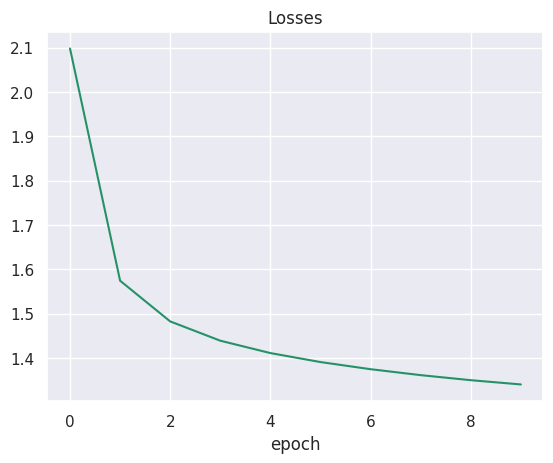

In [19]:
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

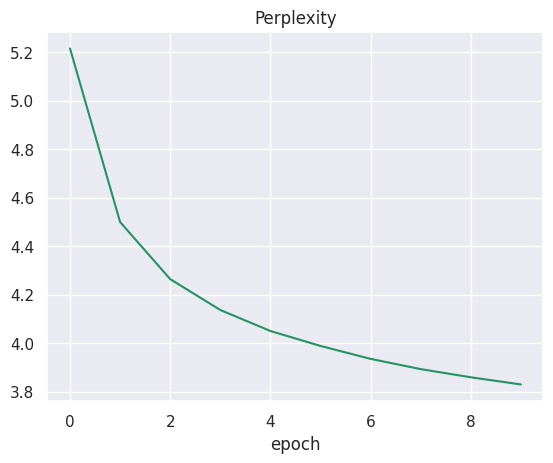

In [20]:
plt.plot(np.arange(len(perplexities)), perplexities)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

## Generation

In [21]:
def generate_sequence(model, starting_seq: str, max_seq_len: int = 128) -> str:
    device = 'cpu'
    model = model.to(device)
    input_ids = [char2ind['<bos>']] + [
        char2ind.get(char, char2ind['<unk>']) for char in starting_seq]
    input_ids = torch.LongTensor(input_ids).to(device)

    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_char_distribution = model(input_ids)[-1]
            next_char = next_char_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_char.unsqueeze(0)])

            if next_char.item() == char2ind['<eos>']:
                break

    words = ''.join([ind2char[idx.item()] for idx in input_ids])

    return words

In [22]:
generate_sequence(model, starting_seq='по системе гол плюс пас ')

'<bos>по системе гол плюс пас произошла в прошлом году в разговоре с продолжения собой в россии.<eos>'